# Customer Segmentation using Clustering
***
This mini-project is based on [this blog post](https://community.alteryx.com/t5/Data-Science/Beginner-s-Guide-to-Customer-Segmentation/ba-p/138442) by yhat. Please feel free to refer to the post for additional information, and solutions.

In [1]:
%matplotlib inline
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

import warnings
warnings.filterwarnings('ignore')

## Data

The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [2]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheet_name=0)
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

offer_id  campaign            varietal  min_qty  discount       origin  \
0         1   January              Malbec       72        56       France   
1         2   January          Pinot Noir       72        17       France   
2         3  February           Espumante      144        32       Oregon   
3         4  February           Champagne       72        48       France   
4         5  February  Cabernet Sauvignon      144        44  New Zealand   

   past_peak  
0      False  
1      False  
2       True  
3       True  
4       True

We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [3]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

customer_name  offer_id  n
0         Smith         2  1
1         Smith        24  1
2       Johnson        17  1
3       Johnson        24  1
4       Johnson        26  1

## Data wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [4]:
# join the offers and transactions table
df = pd.merge(df_offers, df_transactions)
df

# create a pivot table that gives the num of times each customer
# responded to a given offer
matrix = df.pivot_table(
    index=['customer_name'],
    columns=['offer_id'],
    values='n'
)

# fill NA values with 0
# and make the index into a column
matrix = matrix.fillna(0).reset_index()
matrix.head()

offer_id customer_name    1    2    3    4    5    6    7    8    9  ...   23  \
0                Adams  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
1                Allen  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  ...  0.0   
2             Anderson  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
3               Bailey  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...  0.0   
4                Baker  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...  0.0   

offer_id   24   25   26   27   28   29   30   31   32  
0         0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  
1         0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  
2         1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  
3         0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  
4         0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  

[5 rows x 33 columns]

## K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

### Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

In [5]:
# ref: https://support.minitab.com/en-us/minitab/21/help-and-how-to/statistical-modeling/multivariate/how-to/cluster-k-means/interpret-the-results/all-statistics-and-graphs/#:~:text=In%20general%2C%20a%20cluster%20that,the%20observations%20within%20the%20cluster.
# ref: https://www.analyticsvidhya.com/blog/2021/01/in-depth-intuition-of-k-means-clustering-algorithm-in-machine-learning/
'''
I believe lower values of SS represent better clusterings.
A lower SS points to a smaller distance from the centroid
for the points in the cluster.
'''

'\nI believe lower values of SS represent better clusterings.\nA lower SS points to a smaller distance from the centroid\nfor the points in the cluster.\n'

In [6]:
# the columns representing the offers
x_cols = matrix.columns[1:]
x_cols

Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32],
      dtype='object', name='offer_id')

Text(0, 0.5, 'SS')

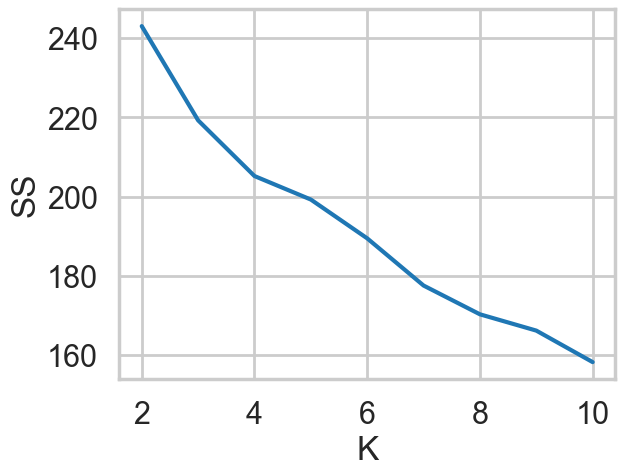

In [7]:
from sklearn.cluster import KMeans

ss={}
for k in range(2, 11):
    cluster = KMeans(n_clusters=k)
    cluster.fit_predict(matrix[matrix.columns[2:]])
    ss[k] = cluster.inertia_
plt.plot(
    ss.keys(),
    ss.values()
)
plt.xlabel('K')
plt.ylabel('SS')

<Axes: >

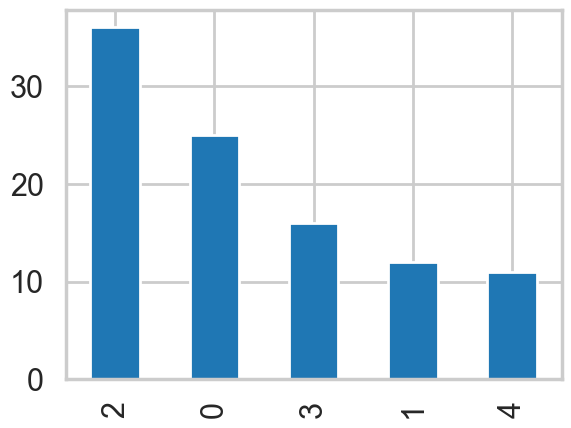

In [8]:
cluster = KMeans(n_clusters=5)
matrix['cluster'] = cluster.fit_predict(matrix[matrix.columns[2:]])
matrix.cluster.value_counts().plot(kind='bar')

In [9]:
'''
The Elbow method is an iterative method so it can be an expensive approach
It a little hard to guess which dip in the K x SS graph is correct "elbow"
'''

'\nThe Elbow method is an iterative method so it can be an expensive approach\nIt a little hard to guess which dip in the K x SS graph is correct "elbow"\n'

### Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

Fortunately, scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

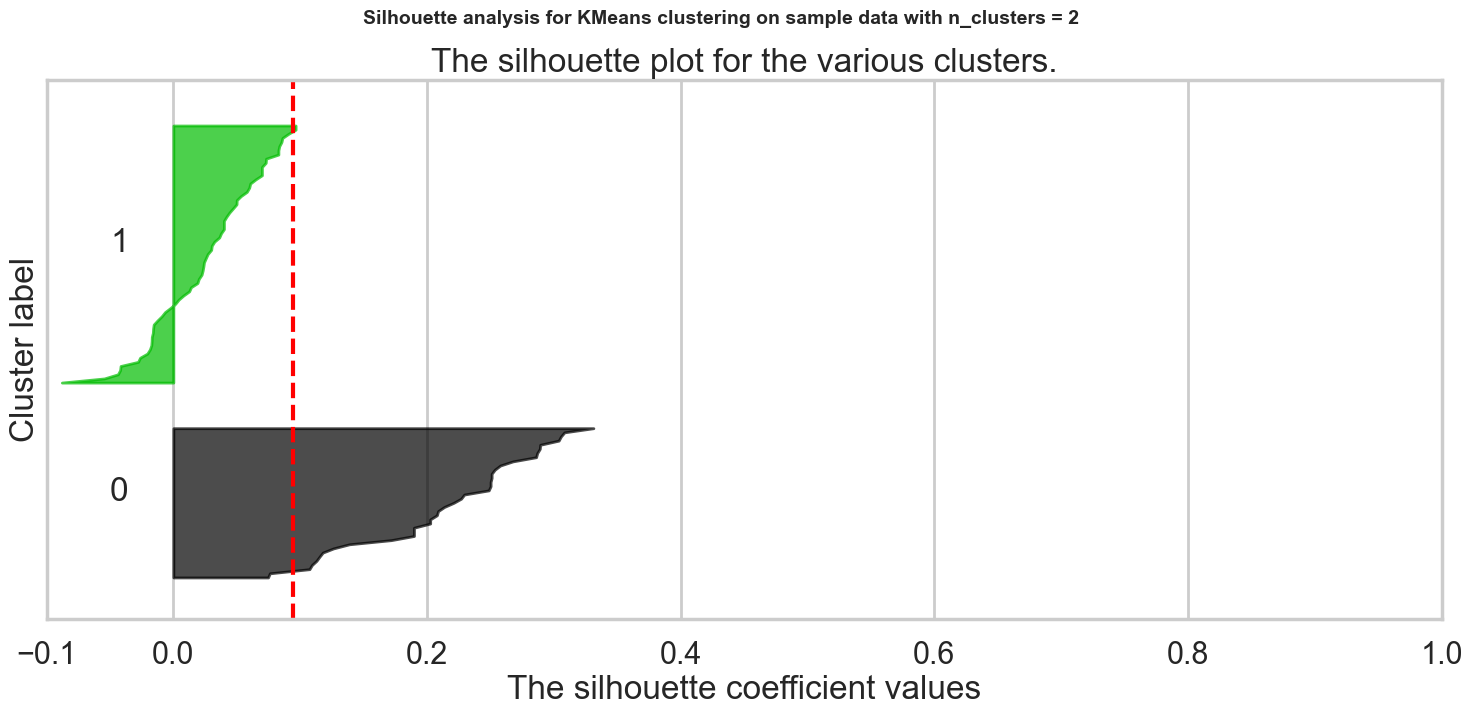

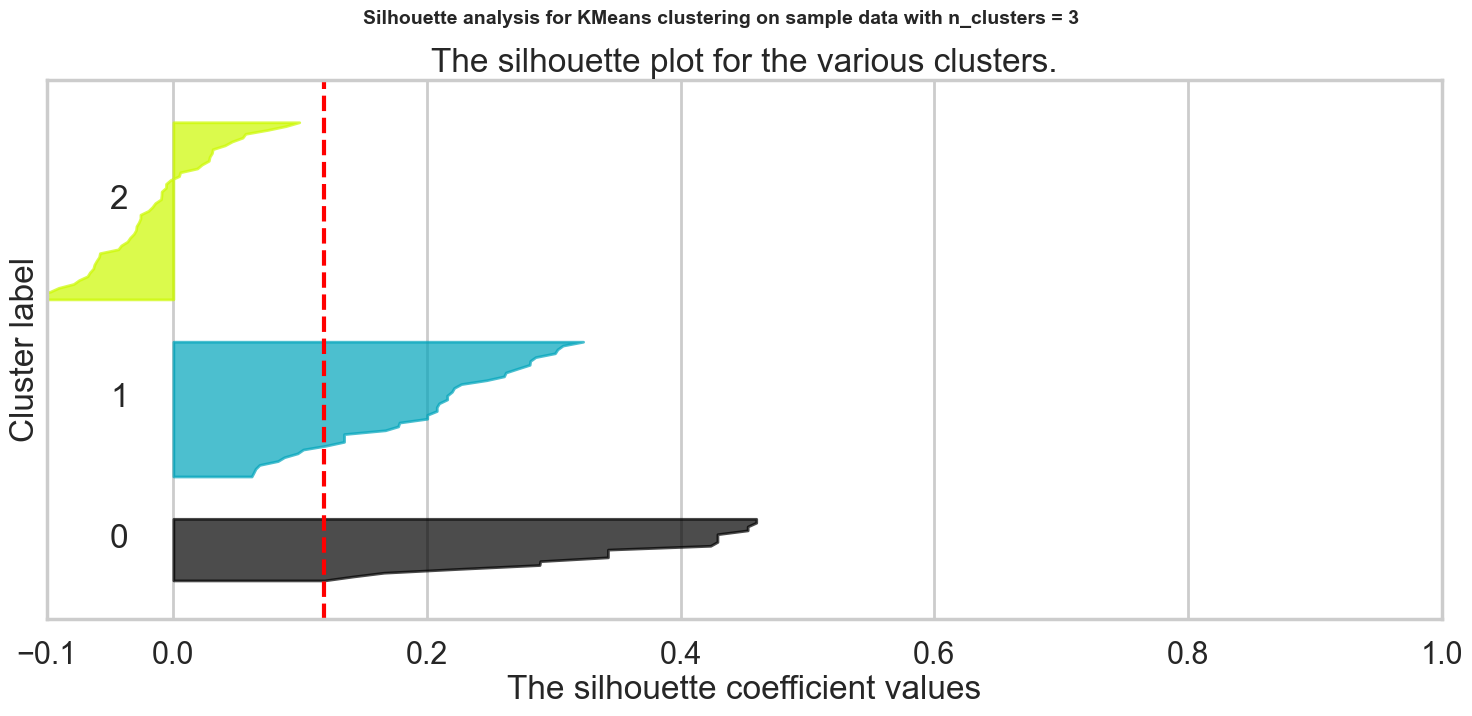

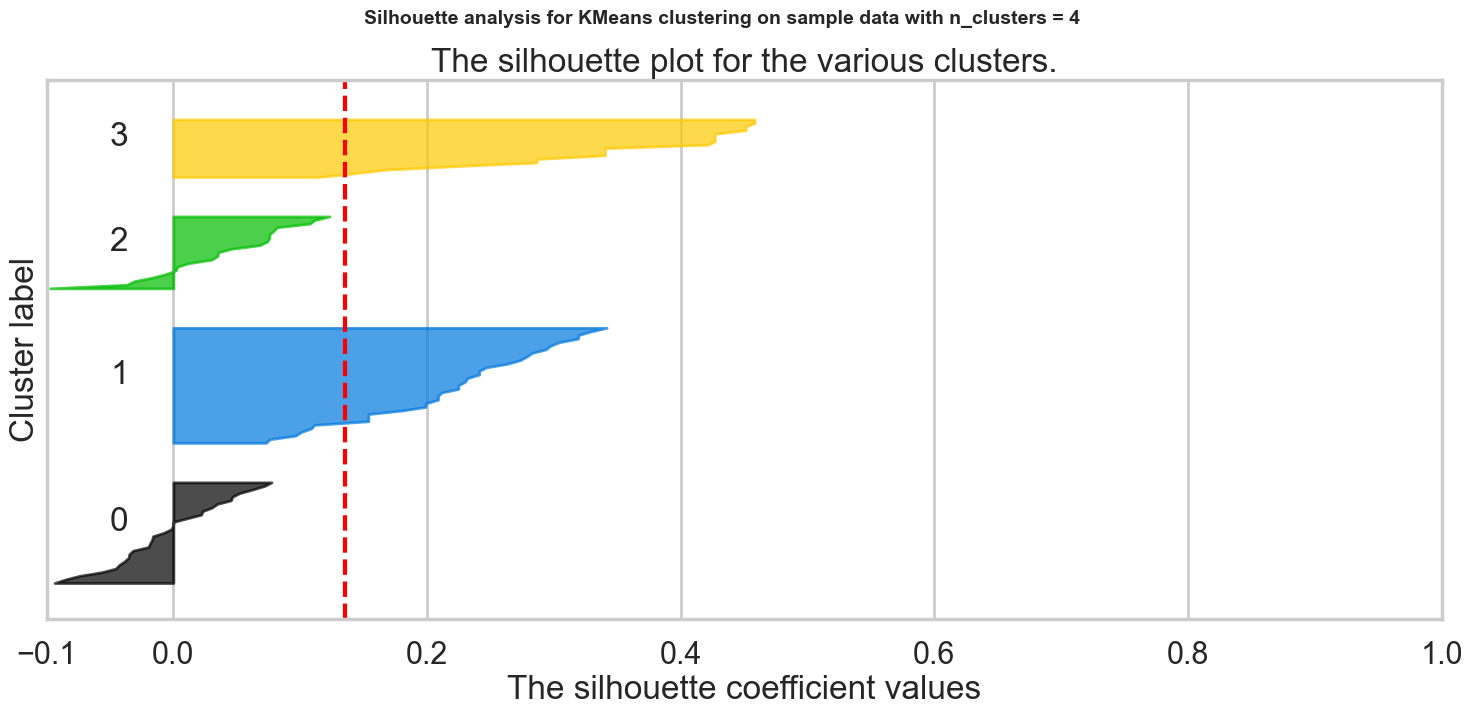

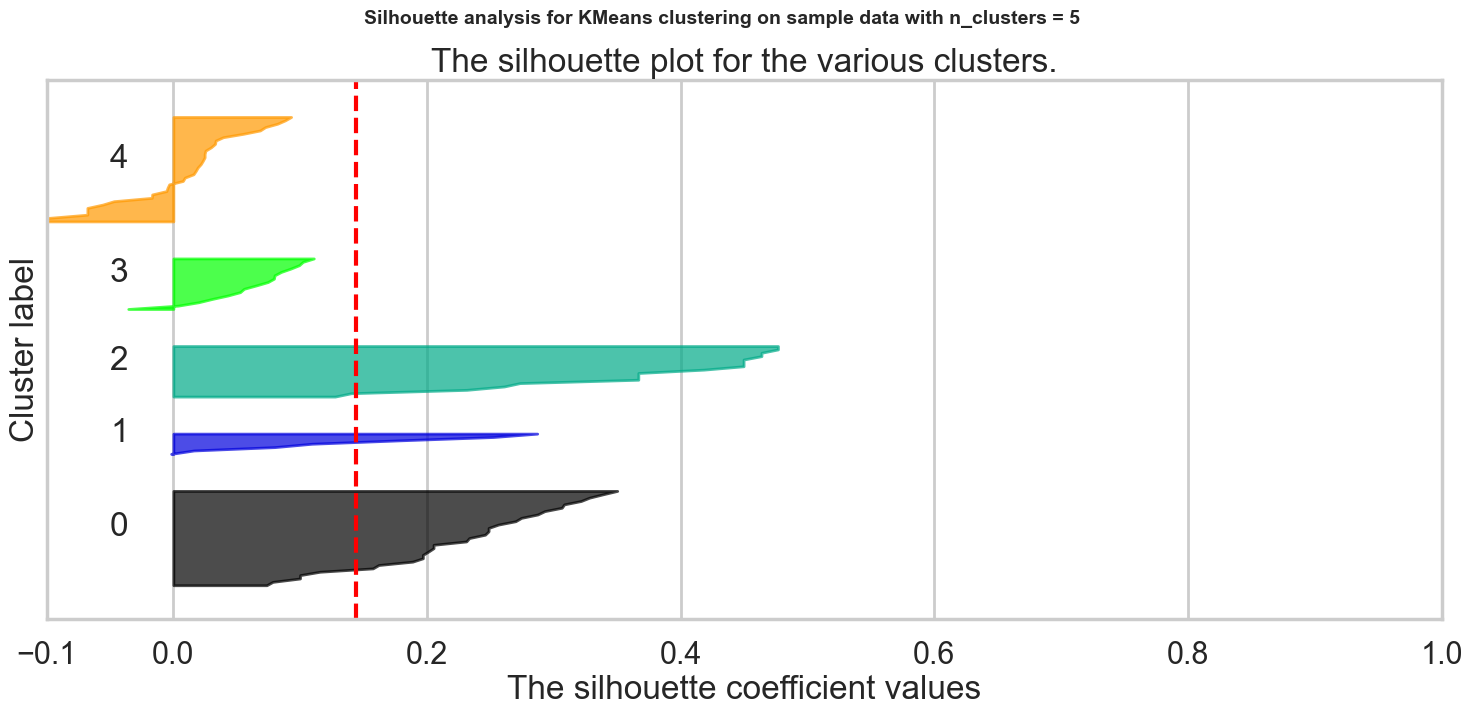

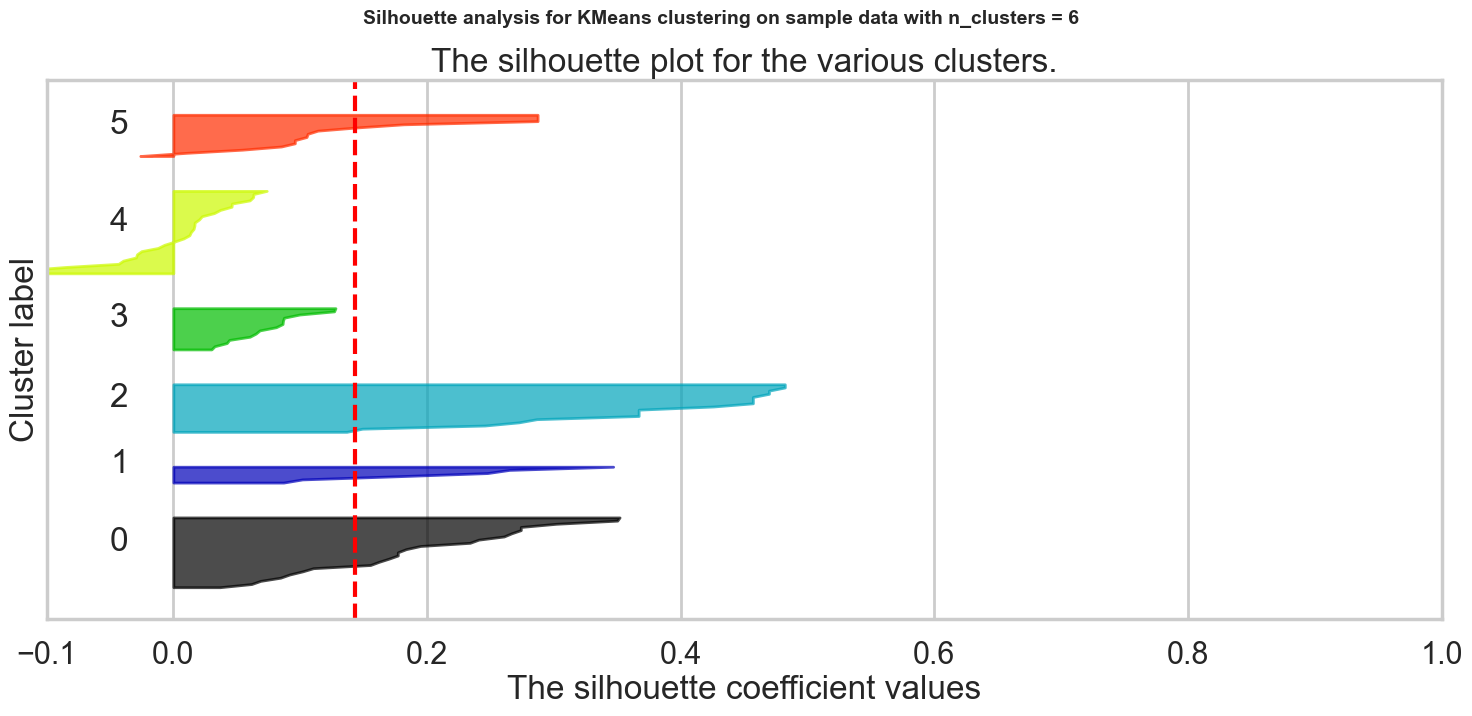

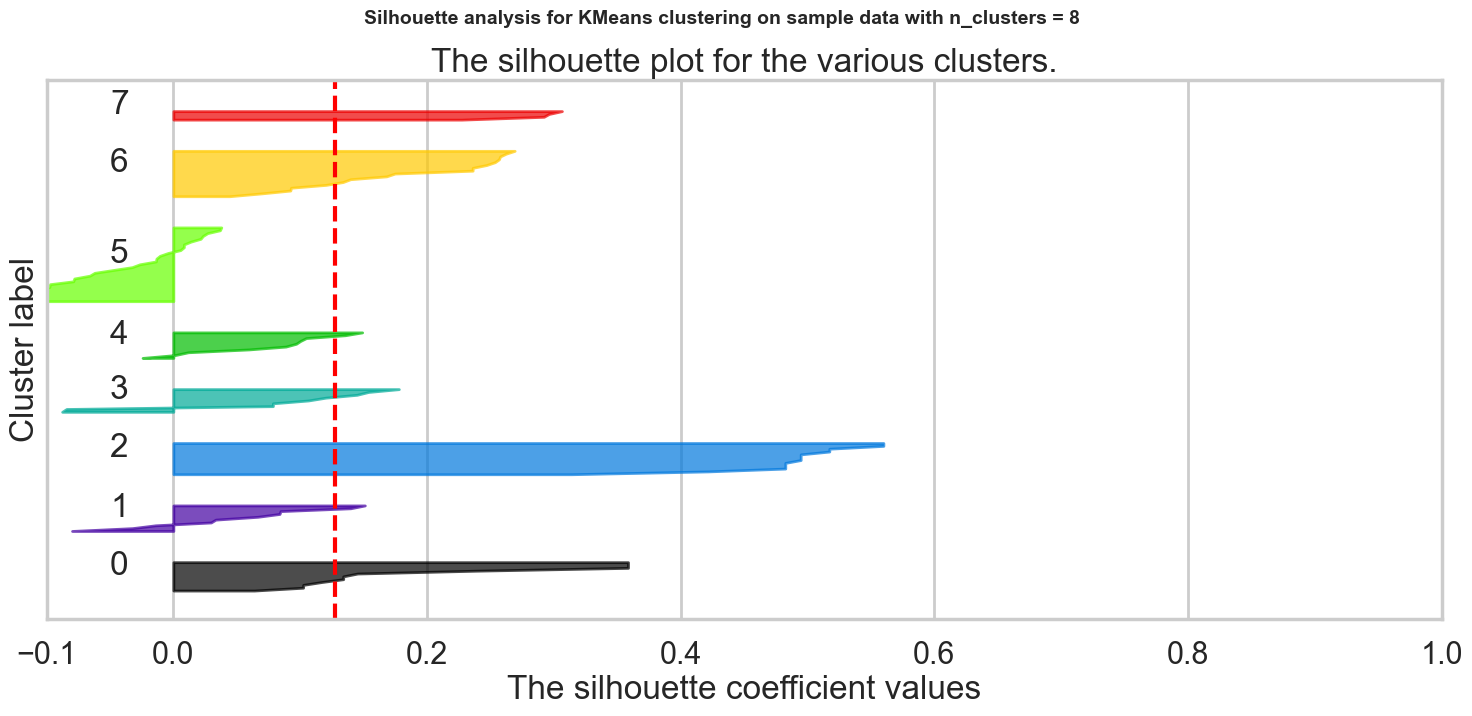

In [10]:
import matplotlib.cm as cm
import numpy as np
from sklearn.metrics import silhouette_samples, silhouette_score

X = matrix[matrix.columns[2:]].drop('cluster', axis=1)

for n_clusters in range(2, 11):
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    
    silhouette_avg = silhouette_score(X, cluster_labels)
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )
        
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        
        y_lower = y_upper + 10

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )


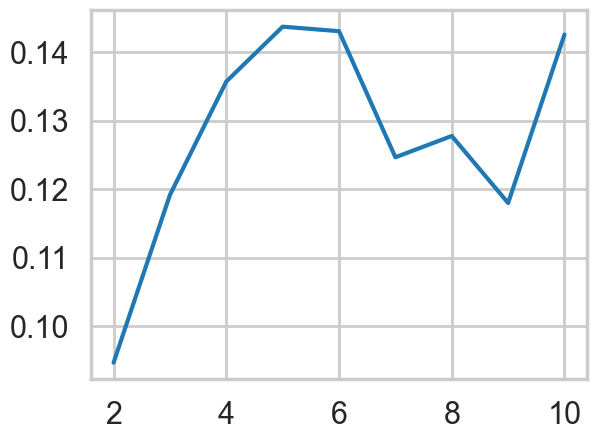

In [11]:
sil_scores = []
X = matrix[matrix.columns[2:]].drop('cluster', axis=1)

k_s = list(range(2,11))
for k in k_s:
    clusterer = KMeans(n_clusters=k, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    
    sil_scores.append(silhouette_score(X, cluster_labels))
    
plt.plot(k_s, sil_scores)

__Q: What  𝐾 does the plot suggest we should choose?__

__Q: Does it differ from what we found using the Elbow method?__

According to the [reading](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html):
>The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar.



- 5 is suggested as the best number of clusters because its score is closest to 1.

- This agrees with the results of the Elbow method in which
5 clusters were suggested.

### Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

## Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

In [12]:
# Use scikit-learn's PCA function to reduce the dimensionality
# of your clustering data to 2 components

from sklearn.decomposition import PCA

X = matrix[matrix.columns[2:]].drop('cluster', axis=1)

pca = PCA(n_components=2)
pca_components = pca.fit_transform(X)
pca_components[:5]

array([[ 1.01490834,  0.15776441],
       [-0.3130428 ,  0.0192679 ],
       [-0.45146179,  1.00811376],
       [ 0.70055076,  0.00600238],
       [ 0.0725744 , -0.49435171]])

In [13]:
matrix.head()

offer_id customer_name    1    2    3    4    5    6    7    8    9  ...   24  \
0                Adams  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
1                Allen  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  ...  0.0   
2             Anderson  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  1.0   
3               Bailey  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...  0.0   
4                Baker  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...  0.0   

offer_id   25   26   27   28   29   30   31   32  cluster  
0         0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0        0  
1         0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0        2  
2         0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0        3  
3         0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0        0  
4         0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0        2  

[5 rows x 34 columns]

In [14]:
# Create a data frame with the following fields:
# - customer name
# - cluster id the customer belongs to
# - the two PCA components (label them `x` and `y`)

pca_df = pd.DataFrame({
    'customer_name': matrix['customer_name'],
    'cluster': matrix['cluster'],
    'x': pca_components[:,0],
    'y': pca_components[:, 1]
})

pca_df.head()

customer_name  cluster         x         y
0         Adams        0  1.014908  0.157764
1         Allen        2 -0.313043  0.019268
2      Anderson        3 -0.451462  1.008114
3        Bailey        0  0.700551  0.006002
4         Baker        2  0.072574 -0.494352

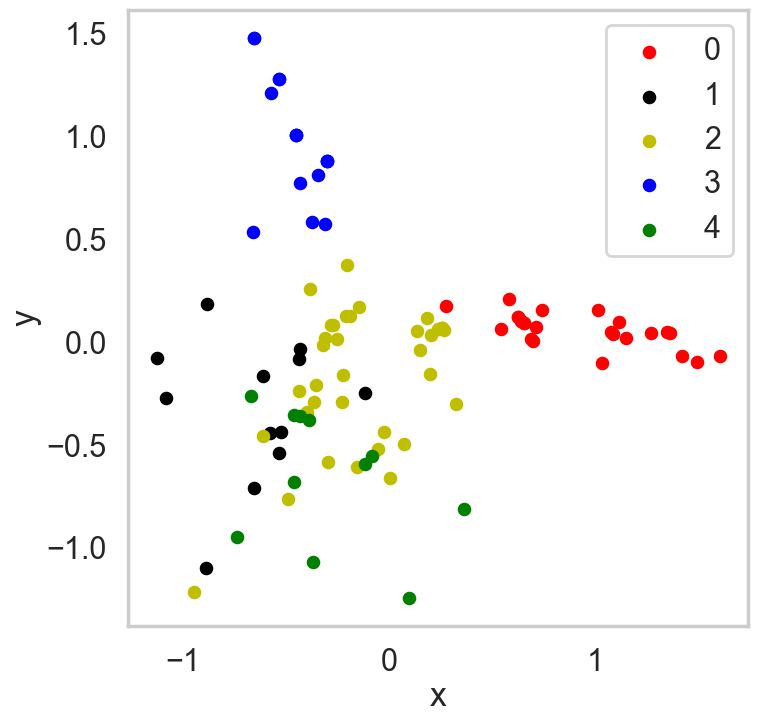

In [15]:
# Plot a scatterplot of the `x` vs `y` columns
# Color-code points differently based on cluster ID

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)

ax.set_xlabel('x')
ax.set_ylabel('y')

cluster_ids=list(pca_df['cluster'].value_counts().index.sort_values())
colors=['r','k','y','b','g']

for cluster_id, color in zip(cluster_ids, colors):
    ax.scatter(
        pca_df[pca_df['cluster'] == cluster_id]['x'],
        pca_df[pca_df['cluster'] == cluster_id]['y'],
        c=color,
        s=60
    )
    
ax.legend(cluster_ids)
ax.grid()

In [16]:
# How do the clusters look?
# Based on what you see, what seems to be the best value for  𝐾? 
# Moreover, which method of choosing  𝐾 seems to have produced 
# the optimal result visually?

'''
In agreement with the results of the previous experiments, 5
clusters would be most appropriate. But there would be a single cluster,
from the points in the middle, that would have probably mis-classify
a lot of the points within it.

The PCA method gives the ability to see the clusters visually
but there is concern about the possible loss of data
that comes from feature reduction. It might be better to use
silhouette plots, this being the case.
'''

'\nIn agreement with the results of the previous experiments, 5\nclusters would be most appropriate. But there would be a single cluster,\nfrom the points in the middle, that would have probably mis-classify\na lot of the points within it.\n\nThe PCA method gives the ability to see the clusters visually\nbut there is concern about the possible loss of data\nthat comes from feature reduction. It might be better to use\nsilhouette plots, this being the case.\n'

In [17]:
# Exercise: Now look at both the original raw data about the 
# offers and transactions and look at the fitted clusters. 
df.head()

offer_id campaign varietal  min_qty  discount  origin  past_peak  \
0         1  January   Malbec       72        56  France      False   
1         1  January   Malbec       72        56  France      False   
2         1  January   Malbec       72        56  France      False   
3         1  January   Malbec       72        56  France      False   
4         1  January   Malbec       72        56  France      False   

  customer_name  n  
0        Thomas  1  
1       Jackson  1  
2      Mitchell  1  
3      Peterson  1  
4          Wood  1

In [18]:
print(matrix.shape)
matrix.head()

(100, 34)


offer_id customer_name    1    2    3    4    5    6    7    8    9  ...   24  \
0                Adams  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
1                Allen  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  ...  0.0   
2             Anderson  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  1.0   
3               Bailey  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...  0.0   
4                Baker  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...  0.0   

offer_id   25   26   27   28   29   30   31   32  cluster  
0         0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0        0  
1         0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0        2  
2         0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0        3  
3         0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0        0  
4         0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0        2  

[5 rows x 34 columns]

In [19]:
print(df_offers.shape)
df_offers.head()

(32, 7)


offer_id  campaign            varietal  min_qty  discount       origin  \
0         1   January              Malbec       72        56       France   
1         2   January          Pinot Noir       72        17       France   
2         3  February           Espumante      144        32       Oregon   
3         4  February           Champagne       72        48       France   
4         5  February  Cabernet Sauvignon      144        44  New Zealand   

   past_peak  
0      False  
1      False  
2       True  
3       True  
4       True

In [20]:
print(df_transactions.shape)
df_transactions.head()

(324, 3)


customer_name  offer_id  n
0         Smith         2  1
1         Smith        24  1
2       Johnson        17  1
3       Johnson        24  1
4       Johnson        26  1

In [21]:
offers_by_cluster = matrix.iloc[:, 1:].groupby('cluster').sum()
offers_by_cluster

offer_id   1    2    3    4    5    6     7     8    9    10  ...   23    24  \
cluster                                                       ...              
0         0.0  0.0  0.0  0.0  0.0  0.0  12.0  11.0  0.0  0.0  ...  0.0   0.0   
1         2.0  0.0  0.0  7.0  2.0  5.0   0.0   0.0  4.0  0.0  ...  0.0   0.0   
2         6.0  3.0  1.0  2.0  2.0  3.0   4.0   5.0  6.0  6.0  ...  4.0   0.0   
3         1.0  6.0  0.0  0.0  0.0  0.0   0.0   0.0  0.0  1.0  ...  1.0  12.0   
4         1.0  1.0  5.0  3.0  0.0  4.0   3.0   4.0  0.0  0.0  ...  0.0   0.0   

offer_id   25    26   27   28    29    30    31   32  
cluster                                               
0         0.0   0.0  0.0  1.0  16.0  16.0   0.0  0.0  
1         2.0   3.0  3.0  1.0   1.0   0.0   5.0  4.0  
2         4.0   0.0  2.0  4.0   0.0   6.0  10.0  0.0  
3         0.0  12.0  1.0  0.0   0.0   0.0   0.0  0.0  
4         0.0   0.0  3.0  0.0   0.0   0.0   2.0  0.0  

[5 rows x 32 columns]

In [22]:
offers_by_cluster_t = offers_by_cluster.transpose()
offers_by_cluster_t

cluster      0    1     2     3     4
offer_id                             
1          0.0  2.0   6.0   1.0   1.0
2          0.0  0.0   3.0   6.0   1.0
3          0.0  0.0   1.0   0.0   5.0
4          0.0  7.0   2.0   0.0   3.0
5          0.0  2.0   2.0   0.0   0.0
6          0.0  5.0   3.0   0.0   4.0
7         12.0  0.0   4.0   0.0   3.0
8         11.0  0.0   5.0   0.0   4.0
9          0.0  4.0   6.0   0.0   0.0
10         0.0  0.0   6.0   1.0   0.0
11         0.0  6.0   3.0   0.0   4.0
12         0.0  0.0   3.0   1.0   1.0
13         6.0  0.0   0.0   0.0   0.0
14         0.0  2.0   7.0   0.0   0.0
15         0.0  3.0   2.0   0.0   1.0
16         0.0  3.0   1.0   1.0   0.0
17         0.0  0.0   0.0   7.0   0.0
18        11.0  0.0   3.0   0.0   0.0
19         0.0  0.0   2.0   0.0   3.0
20         0.0  6.0   0.0   0.0   0.0
21         0.0  1.0   2.0   0.0   1.0
22         0.0  2.0   9.0   0.0  10.0
23         0.0  0.0   4.0   1.0   0.0
24         0.0  0.0   0.0  12.0   0.0
25         0.0  2.0   4.0   0.0   0.0
26         0.0  3.0   0.0  12.0   0.0
27         0.0  3.0   2.0   1.0   3.0
28         1.0  1.0   4.0   0.0   0.0
29        16.0  1.0   0.0   0.0   0.0
30        16.0  0.0   6.0   0.0   0.0
31         0.0  5.0  10.0   0.0   2.0
32         0.0  4.0   0.0   0.0   0.0

In [23]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:2000px;
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>
<!--ref: https://stackoverflow.com/questions/18770504/resize-ipython-notebook-output-window-->

In [24]:
df_offers

offer_id   campaign            varietal  min_qty  discount        origin  \
0          1    January              Malbec       72        56        France   
1          2    January          Pinot Noir       72        17        France   
2          3   February           Espumante      144        32        Oregon   
3          4   February           Champagne       72        48        France   
4          5   February  Cabernet Sauvignon      144        44   New Zealand   
5          6      March            Prosecco      144        86         Chile   
6          7      March            Prosecco        6        40     Australia   
7          8      March           Espumante        6        45  South Africa   
8          9      April          Chardonnay      144        57         Chile   
9         10      April            Prosecco       72        52    California   
10        11        May           Champagne       72        85        France   
11        12        May            Prosecco       72        83     Australia   
12        13        May              Merlot        6        43         Chile   
13        14       June              Merlot       72        64         Chile   
14        15       June  Cabernet Sauvignon      144        19         Italy   
15        16       June              Merlot       72        88    California   
16        17       July          Pinot Noir       12        47       Germany   
17        18       July           Espumante        6        50        Oregon   
18        19       July           Champagne       12        66       Germany   
19        20     August  Cabernet Sauvignon       72        82         Italy   
20        21     August           Champagne       12        50    California   
21        22     August           Champagne       72        63        France   
22        23  September          Chardonnay      144        39  South Africa   
23        24  September          Pinot Noir        6        34         Italy   
24        25    October  Cabernet Sauvignon       72        59        Oregon   
25        26    October          Pinot Noir      144        83     Australia   
26        27    October           Champagne       72        88   New Zealand   
27        28   November  Cabernet Sauvignon       12        56        France   
28        29   November        Pinot Grigio        6        87        France   
29        30   December              Malbec        6        54        France   
30        31   December           Champagne       72        89        France   
31        32   December  Cabernet Sauvignon       72        45       Germany   

    past_peak  
0       False  
1       False  
2        True  
3        True  
4        True  
5       False  
6        True  
7       False  
8       False  
9       False  
10      False  
11      False  
12      False  
13      False  
14      False  
15      False  
16      False  
17      False  
18      False  
19      False  
20      False  
21      False  
22      False  
23      False  
24       True  
25      False  
26      False  
27       True  
28      False  
29      False  
30      False  
31       True

In [25]:
fig, ax = plt.subplots(len(offers_by_cluster_t.columns), figsize=(30,70)) 
colors=['r','k','y','b', 'g']

for col, color in zip(offers_by_cluster_t.columns, colors):
    ax[col].set_title(f'Cluster {col} (Campign, Varietal)')
    ax[col].set_xlabel('offer_id')
    ax[col].set_ylabel('Cluster freq')
    
    p = ax[col].plot(offers_by_cluster_t[col], color=color)
    
    offer_id = 1
    
#     ref: https://stackoverflow.com/questions/29832770/getting-point-coordinates-from-matplotlib-pyplot-plot
    for x,y in zip(p[0].get_data()[0],p[0].get_data()[1]):
        offer = df_offers[df_offers['offer_id'] == offer_id]
        campaign = offer['campaign'].values[0]
        varietal = offer['varietal'].values[0]
        ax[col].annotate(
            f"{campaign}, {varietal}",
            (x,y),
            xytext=(15, 15),
            textcoords='offset points',
            rotation=80
        )
        
        offer_id += 1
    

fig.tight_layout()

In [26]:
# Tell a story about the clusters in context of the original data. 
# For example, do the clusters correspond to wine variants or 
# something else interesting?

'''
For certain clusters there are periods / campaigns in which there will
be a spike for the cluster. This is the case except for cluster 4
which has a spike in the December(campaign)/Champagne(varietal) but
is otherwise patternless.
'''

'\nFor certain clusters there are periods / campaigns in which there will\nbe a spike for the cluster. This is the case except for cluster 4\nwhich has a spike in the December(campaign)/Champagne(varietal) but\nis otherwise patternless.\n'

What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

'\nIt looks like "20" would be the optimal number of dimensions\n'

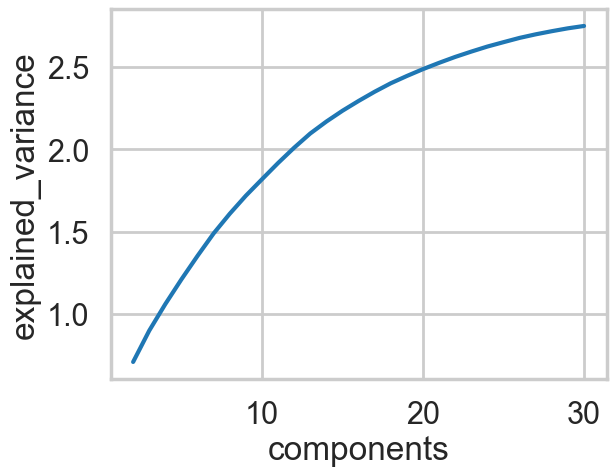

In [27]:
#your turn
# Initialize a new PCA model with a default number of components.
# import sklearn.decomposition
# pca = sklearn.decomposition.PCA()
# pca.fit(X)

# Do the rest on your own :)
ev={}
for c in range(2, 31):
    pca = PCA(n_components=c)
    pca.fit(X)
    ev[c] = pca.explained_variance_.sum()
    

plt.plot(
    ev.keys(),
    ev.values()
)
plt.xlabel('components')
plt.ylabel('explained_variance')

'''
It looks like "20" would be the optimal number of dimensions
'''

## Other Clustering Algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


In [28]:
from sklearn.cluster import AffinityPropagation

af = AffinityPropagation(random_state=0).fit(X)
silhouette_score(X, af.labels_)

0.1276758798641375

In [29]:
from sklearn.cluster import SpectralClustering

sc = SpectralClustering(n_clusters=5, random_state=0).fit(X)
silhouette_score(X, sc.labels_)

0.10835216337369222

In [30]:
from sklearn.cluster import AgglomerativeClustering

agc = AgglomerativeClustering().fit(X)
silhouette_score(X, agc.labels_)

0.0881375625640959

In [31]:
from sklearn.cluster import DBSCAN

dbs = DBSCAN(min_samples=2).fit(X)
silhouette_score(X, dbs.labels_)

-0.0194757804090745

In [32]:
# How do their results compare?
# Which performs the best?
# Tell a story why you think it performs the best.
'''
All of the methods used without tuning have a really low silhouette_score.
AffinityPropagation does the best in terms of the silhouette_score.
DBSCAN does the worst.

AffinityPropagation may have done the best because the clusters that
have been determined are somewhat unstable and uneven.
'''

'\nAll of the methods used without tuning have a really low silhouette_score.\nAffinityPropagation does the best in terms of the silhouette_score.\nDBSCAN does the worst.\n\nAffinityPropagation may have done the best because the clusters that\nhave been determined are somewhat unstable and uneven.\n'